In [1]:
lang_1 = 'vietnamese'
lang_2 = 'cantonese'
color = [127, 127, 255]

In [2]:
import pandas as pd

In [3]:
import unicodedata

In [4]:
import os
path = os.getcwd()
path

'/Users/ryanphung/Projects/Linguistics/sino-tones-pairing'

In [5]:
df = pd.read_csv('unihan/unihan.txt', sep='\t', keep_default_na=False)
df

,character,language,value
0,U+3400,kCantonese,jau1
1,U+3400,kDefinition,(same as U+4E18 丘) hillock or mound
2,U+3400,kMandarin,qiū
3,U+3401,kCantonese,tim2
4,U+3401,kDefinition,"to lick; to taste, a mat, bamboo bark"
...,...,...,...
196650,U+30729,kHangul,은:N
196651,U+30EDD,kDefinition,biangbiang noodles
196652,U+30EDD,kMandarin,biáng
196653,U+30EDE,kDefinition,biangbiang noodles


In [6]:
tones = {
    "mandarin": {
        1: [0x304, "Tone 1 (mā)"],
        2: [0x301, "Tone 2 (má)"],
        3: [0x30c, "Tone 3 (mǎ)"],
        4: [0x300, "Tone 4 (mà)"],
        5: [None, "Tone 5 (ma)"]
    },
    "vietnamese": {
        1: [None, "Không"],
        2: [0x309, "Hỏi"],
        3: [0x301, "Sắc"],
        4: [0x300, "Huyền"],
        5: [0x303, "Ngã"],
        6: [0x323, "Nặng"]
    },
    "cantonese": {
        1: [ord("1"), "Tone 1"],
        2: [ord("2"), "Tone 2"],
        3: [ord("3"), "Tone 3"],
        4: [ord("4"), "Tone 4"],
        5: [ord("5"), "Tone 5"],
        6: [ord("6"), "Tone 6"]
    }
}

def to_tone(lang, s):
    the_tones = tones[lang]
    a = unicodedata.normalize('NFD', s)
    for ch in a:
        for i in the_tones:
            if the_tones[i][0] != None and ord(ch) == the_tones[i][0]:
                return i
    return [x for x in the_tones if the_tones[x][0] == None][0]

def test_to_tone(lang):
    print('---')
    print(lang)
    the_tones = tones[lang]
    for i in the_tones:
        print(the_tones[i][1], ':', to_tone(lang, the_tones[i][1]))

test_to_tone("vietnamese")
test_to_tone("mandarin")
test_to_tone("cantonese")

---
vietnamese
Không : 1
Hỏi : 2
Sắc : 3
Huyền : 4
Ngã : 5
Nặng : 6
---
mandarin
Tone 1 (mā) : 1
Tone 2 (má) : 2
Tone 3 (mǎ) : 3
Tone 4 (mà) : 4
Tone 5 (ma) : 5
---
cantonese
Tone 1 : 1
Tone 2 : 2
Tone 3 : 3
Tone 4 : 4
Tone 5 : 5
Tone 6 : 6


In [11]:
def join(df, lang_1, lang_2):
    df_1 = df.loc[df['language'] == 'k' + lang_1.capitalize()]
    df_2 = df.loc[df['language'] == 'k' + lang_2.capitalize()]
    df_joined = df_1.set_index('character').join(df_2.set_index('character'), on='character', how='inner', lsuffix='_lang_1', rsuffix='_lang_2').filter(items=['character', 'value_lang_1', 'value_lang_2'])

    df_joined['tone_lang_1'] = df_joined.apply(lambda row: to_tone(lang_1, row['value_lang_1']), axis=1)
    df_joined['tone_lang_2'] = df_joined.apply(lambda row: to_tone(lang_2, row['value_lang_2']), axis=1)
    return df_joined

# join(df, 'vietnamese', 'mandarin')

,value_lang_1,value_lang_2,tone_lang_1,tone_lang_2
character,,,,
U+34DF,phay,pí,1,2
U+34E0,chẻm,diàn,2,4
U+34F6,khía,qiè,3,4
U+356D,êu,āo,1,1
U+3570,mau,xuè,1,4
...,...,...,...,...
U+2A105,sét,shā,3,1
U+2A10C,ngỗng,gòng,5,4
U+2A138,trích,jí,3,2


In [13]:
def count(df_joined):
    return df_joined.groupby(['tone_lang_1', 'tone_lang_2']).size().unstack()

# count(join(df, 'vietnamese', 'mandarin'))

In [82]:
# import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

def visualize(df_count, lang_1, lang_2, row_lang, col_lang, color_low = [255, 255, 255], color_high = [127, 127, 127]):
    df = (df_count.transpose() / df_count.transpose().sum()).transpose()
    # to calculate global %
#     df = df_count / df_count.sum().sum()
    
    max_value = df.max().max()
    
    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')

    t=ax.table(
        cellText=df.applymap('{:.2%}'.format).values,
        cellColours=df.applymap(lambda v:'#%02x%02x%02x' % tuple(round(low + (high - low) * v / max_value) for low, high in zip(color_low, color_high))).values,
        colWidths=[0.3]*len(df.columns),
        colLabels=df.columns.map(lambda x:tones[col_lang][x][1]),
        rowLabels=df.index.map(lambda x:tones[row_lang][x][1]),
        loc='center')
    t.scale(1, 4)
    t.set_fontsize(12)
    plt.savefig('outputs/tone-pairing-' + lang_1 + '-' + lang_2 +'.png',
        bbox_inches='tight',
        dpi=150
    )
    plt.show()

Tones mapping Vietnamese --> Mandarin:


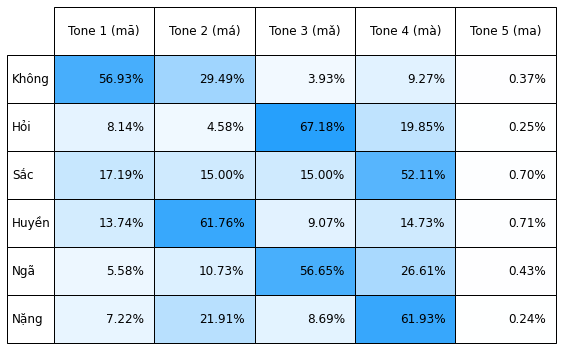

Tones mapping Mandarin --> Vietnamese:


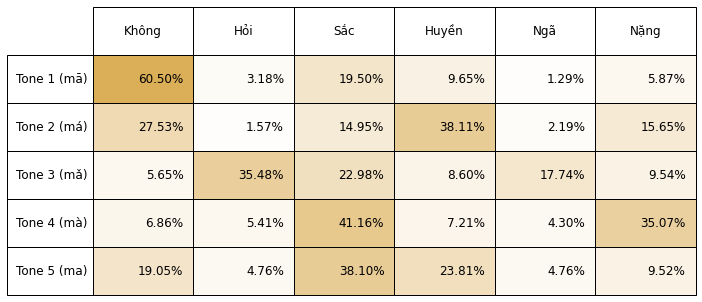

Tones mapping Vietnamese --> Cantonese:


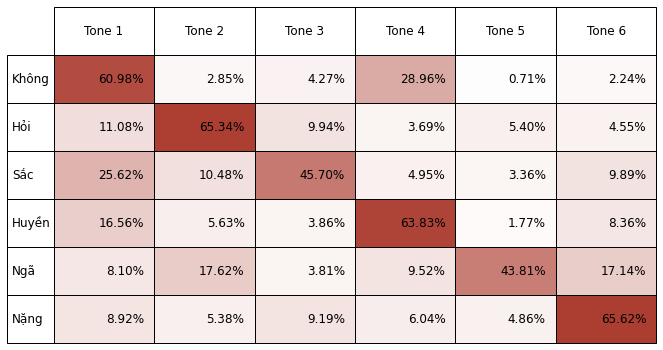

Tones mapping Cantonese --> Vietnamese:


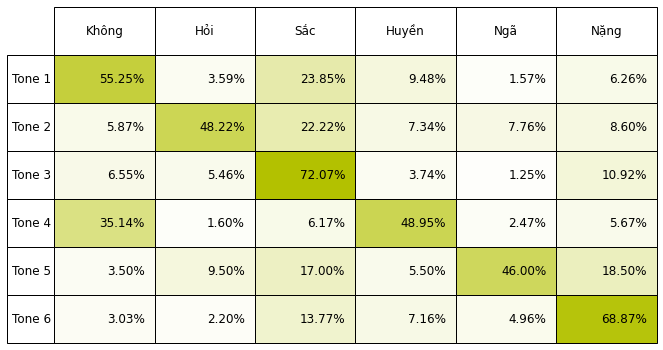

Tones mapping Cantonese --> Mandarin:


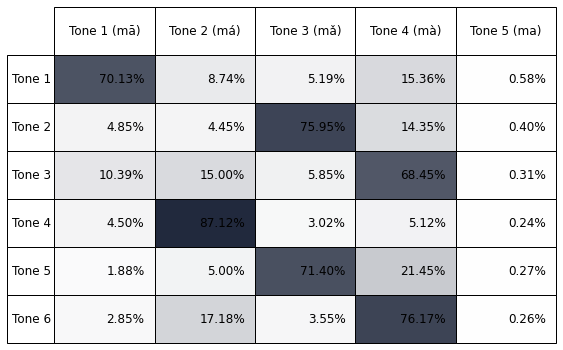

Tones mapping Mandarin --> Cantonese:


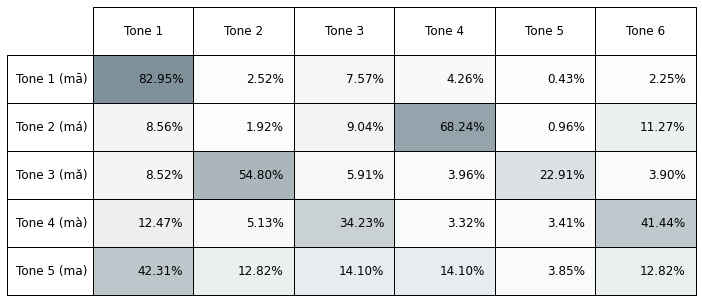

In [83]:
def process(df, lang_1, lang_2, color_low=[255,255,255], color_high=[0,0,0]):
    print('Tones mapping ' + lang_1.capitalize() + ' --> ' + lang_2.capitalize() + ':')
    df_joined = join(df, lang_1, lang_2)
#     return df_joined.head()
    
    df_count = count(df_joined)
#     return df_count

    visualize(
        df_count,
        lang_1=lang_1,
        lang_2=lang_2,
        row_lang=lang_1,
        col_lang=lang_2,
        color_low = color_low,
        color_high = color_high
    )
    
process(df, 'vietnamese', 'mandarin', color_high=[38,160,252])
process(df, 'mandarin', 'vietnamese', color_high=[219,174,88])

process(df, 'vietnamese', 'cantonese', color_high=[172,62,49])
process(df, 'cantonese', 'vietnamese', color_high=[179,193,0])

process(df, 'cantonese', 'mandarin', color_high=[33,41,61])
process(df, 'mandarin', 'cantonese', color_high=[126,144,154])